# Lesson 6: Advanced chromatographic processes


In this lesson we will learn how to create more complex models with binding, multiple components, and multiple unit operations


### Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Example 1: Modelling dispersion of valves and tubing

A real system does not have an inlet connected directly to the column which connects directly to the outlet.
Real systems have tubes and mixing valves. 
If they are not accounted for, the pulse that arrives at the column inlet will be far too sharp.
Moreover, the measured output signal from your column will be appear more diffuse than the real column outlet, because it will have spent time in tubing between the outlet and the detector.

We can model this, by introducing additional unit operations that can account for the time shift and dispersion that is introduced by the periphery of the column.
For this example, we will model the mixer at the inlet using a `CSTR`.
Moreover, in this example we will use two `INLETS` and modify `switches` to create the inlet profile.

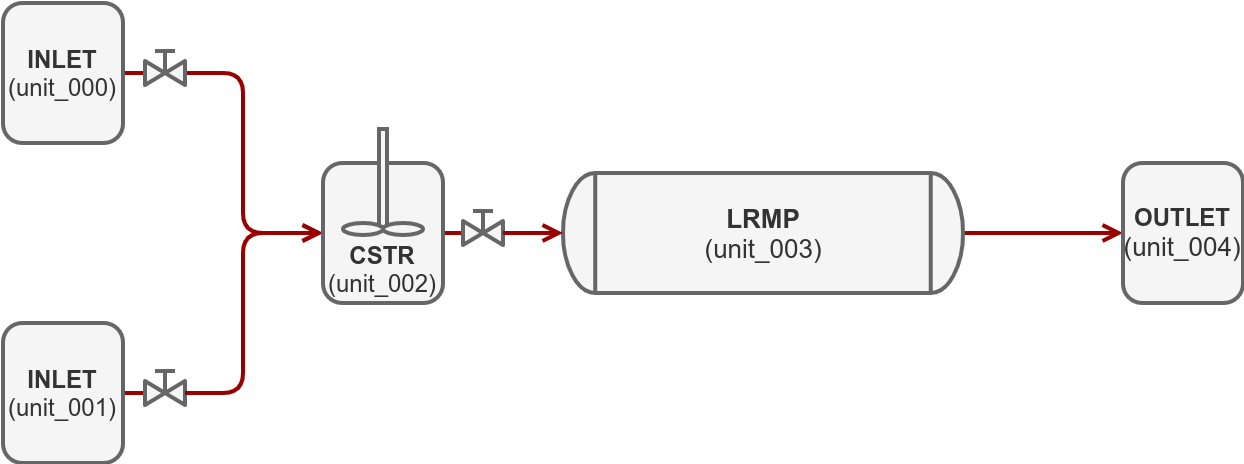

In [2]:
langmuir_model = get_cadet_template(n_units=5)

n_comp = 2
t_cycle = 3600

# Feed
langmuir_model.root.input.model.unit_000.unit_type = 'INLET'
langmuir_model.root.input.model.unit_000.ncomp = n_comp
langmuir_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

# INLET
langmuir_model.root.input.model.unit_001.unit_type = 'INLET'
langmuir_model.root.input.model.unit_001.ncomp = n_comp
langmuir_model.root.input.model.unit_001.inlet_type = 'PIECEWISE_CUBIC_POLY'

# Mixer
langmuir_model.root.input.model.unit_002.unit_type = 'CSTR'
langmuir_model.root.input.model.unit_002.ncomp = n_comp
langmuir_model.root.input.model.unit_002.init_volume =1e-6
langmuir_model.root.input.model.unit_002.init_c = n_comp*[0.0]

# Column
langmuir_model.root.input.model.unit_003.unit_type = 'LUMPED_RATE_MODEL_WITH_PORES'
langmuir_model.root.input.model.unit_003.ncomp = n_comp

langmuir_model.root.input.model.unit_003.col_length = 0.6
langmuir_model.root.input.model.unit_003.cross_section_area = 1.0386890710931253E-4
langmuir_model.root.input.model.unit_003.col_porosity = 0.37
langmuir_model.root.input.model.unit_003.par_porosity = 0.33
langmuir_model.root.input.model.unit_003.par_radius = 4.5e-5

langmuir_model.root.input.model.unit_003.col_dispersion = 2.0e-7
langmuir_model.root.input.model.unit_003.film_diffusion = [1e-4, 1e-4]

langmuir_model.root.input.model.unit_003.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'
langmuir_model.root.input.model.unit_003.adsorption.is_kinetic = False
langmuir_model.root.input.model.unit_003.adsorption.mcl_ka = [2, 3]
langmuir_model.root.input.model.unit_003.adsorption.mcl_kd = [1, 1]
langmuir_model.root.input.model.unit_003.adsorption.mcl_qmax = [1, 1]

langmuir_model.root.input.model.unit_003.init_c = n_comp*[0.0,]
langmuir_model.root.input.model.unit_003.init_q = n_comp*[0.0,]

## Outlet
langmuir_model.root.input.model.unit_004.unit_type = 'OUTLET'
langmuir_model.root.input.model.unit_004.ncomp = n_comp

set_discretization(langmuir_model, n_col=40, n_bound=n_comp*[1])

## Sections and Connections
langmuir_model.root.input.solver.sections.nsec = 2
langmuir_model.root.input.solver.sections.section_times = [0.0, 50.0, t_cycle]
langmuir_model.root.input.solver.sections.section_continuity = [0]

langmuir_model.root.input.model.unit_000.sec_000.const_coeff = n_comp*[1.0]
langmuir_model.root.input.model.unit_001.sec_000.const_coeff = n_comp*[0.0]

langmuir_model.root.input.model.connections.nswitches = 2
langmuir_model.root.input.model.connections.switch_000.section = 0
langmuir_model.root.input.model.connections.switch_000.connections = [
    0, 2, -1, -1, 2.88e-8,
    2, 3, -1, -1, 2.88e-8,
    3, 4, -1, -1, 2.88e-8,
]

langmuir_model.root.input.model.connections.switch_001.section = 1
langmuir_model.root.input.model.connections.switch_001.connections = [
    1, 2, -1, -1, 2.88e-8,
    2, 3, -1, -1, 2.88e-8,
    3, 4, -1, -1, 2.88e-8,
]

# set the times that the simulator writes out data for
langmuir_model.root.input.solver.user_solution_times = np.linspace(0, t_cycle, 601)

Simulation completed successfully


Text(0, 0.5, '$concentration~/~mM$')

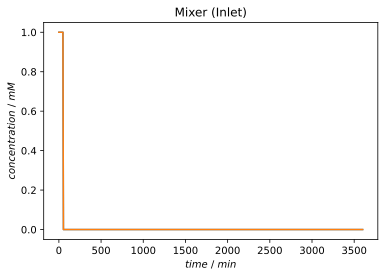

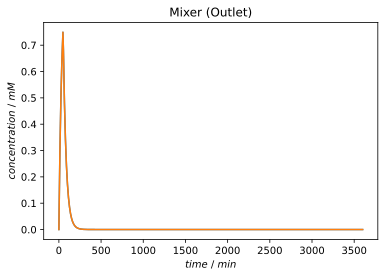

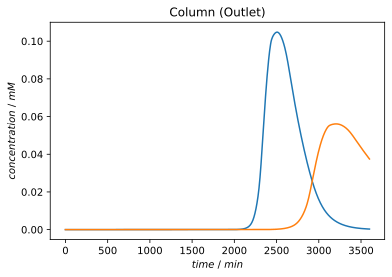

In [3]:
run_simulation(langmuir_model)

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_002.solution_inlet
plt.figure()
plt.plot(time, c)
plt.title('Mixer (Inlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_002.solution_outlet
plt.figure()
plt.plot(time, c)
plt.title('Mixer (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')

time = langmuir_model.root.output.solution.solution_times
c = langmuir_model.root.output.solution.unit_003.solution_outlet
plt.figure()
plt.plot(time, c)
plt.title('Column (Outlet)')
plt.xlabel('$time~/~min$')
plt.ylabel('$concentration~/~mM$')

## Simulated Moving Bed (Cyclic Systems)

CADET can also simulate much more complex systems. 
We will briefly look over a simulated moving bed example.
Simulated moving bed (SMB) is a system of multiple connected columns, in which a counter-current of the stationary phase is 'simulated' by periodically switching column positions.

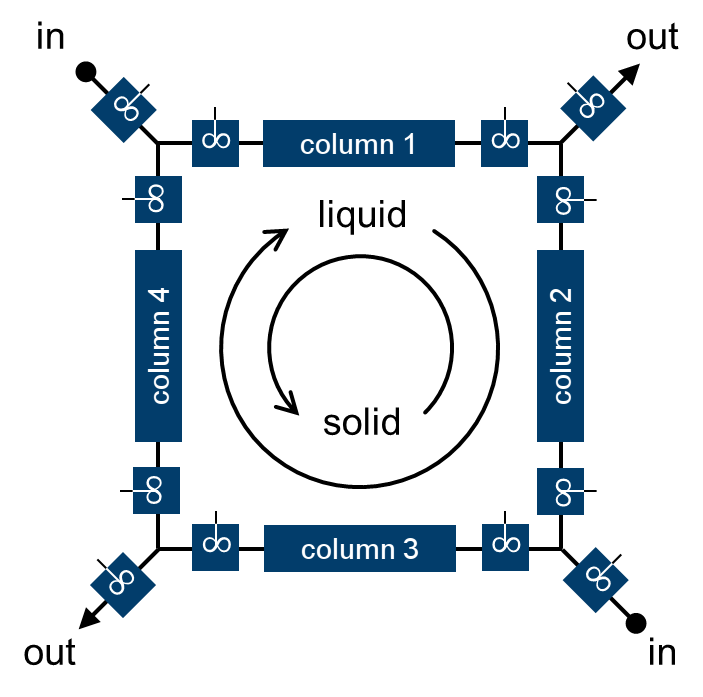

We will briefly look over how these systems are setup but won't go into it in detail.

In [4]:
smb_model = get_cadet_template(n_units=8)

## Feed
smb_model.root.input.model.unit_000.unit_type = 'INLET'
smb_model.root.input.model.unit_000.ncomp = 2
smb_model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

## Eluent
smb_model.root.input.model.unit_001.unit_type = 'INLET'
smb_model.root.input.model.unit_001.ncomp = 2
smb_model.root.input.model.unit_001.inlet_type = 'PIECEWISE_CUBIC_POLY'

## Extract 
smb_model.root.input.model.unit_002.ncomp = 2
smb_model.root.input.model.unit_002.unit_type = 'OUTLET'

## Raffinate
smb_model.root.input.model.unit_003.ncomp = 2
smb_model.root.input.model.unit_003.unit_type = 'OUTLET'

## Columns
smb_model.root.input.model.unit_004.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
smb_model.root.input.model.unit_004.ncomp = 2

smb_model.root.input.model.unit_004.col_dispersion = 3.8148E-20
smb_model.root.input.model.unit_004.col_length = 0.25
smb_model.root.input.model.unit_004.total_porosity = 0.83
smb_model.root.input.model.unit_004.velocity = 1
smb_model.root.input.model.unit_004.cross_section_area = 3.141592653589793E-4

smb_model.root.input.model.unit_004.adsorption_model = 'LINEAR'
smb_model.root.input.model.unit_004.adsorption.is_kinetic = 0
smb_model.root.input.model.unit_004.adsorption.lin_ka = [5.72, 7.7]
smb_model.root.input.model.unit_004.adsorption.lin_kd = [1.0, 1.0]

smb_model.root.input.model.unit_004.init_c = [0.0,0.0]
smb_model.root.input.model.unit_004.init_q = [0.0,0.0]

### Copy column models
smb_model.root.input.model.unit_005 = smb_model.root.input.model.unit_004
smb_model.root.input.model.unit_006 = smb_model.root.input.model.unit_004
smb_model.root.input.model.unit_007 = smb_model.root.input.model.unit_004

### Discretization column settings
set_discretization(smb_model, n_col=40, n_bound=[1,1])

In [5]:
n_cycles = 10
switch_time = 180

# Sections
smb_model.root.input.solver.sections.nsec = 4*n_cycles
smb_model.root.input.solver.sections.section_times = [0]
for i in range(n_cycles):
    smb_model.root.input.solver.sections.section_times.append((4*i+1)*switch_time)
    smb_model.root.input.solver.sections.section_times.append((4*i+2)*switch_time)
    smb_model.root.input.solver.sections.section_times.append((4*i+3)*switch_time)
    smb_model.root.input.solver.sections.section_times.append((4*i+4)*switch_time)    

## Feed and Eluent concentration
smb_model.root.input.model.unit_000.sec_000.const_coeff = [0.003,0.003]
smb_model.root.input.model.unit_001.sec_000.const_coeff = [0.0,0.0]

In [6]:
# Connections
smb_model.root.input.model.connections.nswitches = 4

smb_model.root.input.model.connections.switch_000.section = 0
smb_model.root.input.model.connections.switch_000.connections = [
    4, 5, -1, -1, 7.66e-7,
    5, 6, -1, -1, 7.66e-7,
    6, 7, -1, -1, 8.08e-7,
    7, 4, -1, -1, 8.08e-7,
    0, 4, -1, -1, 0.98e-7,
    1, 6, -1, -1, 1.96e-7,
    4, 2, -1, -1, 1.4e-7,
    6, 3, -1, -1, 1.54e-7
]

smb_model.root.input.model.connections.switch_001.section = 1
smb_model.root.input.model.connections.switch_001.connections = [
    4, 5, -1, -1, 8.08e-7,
    5, 6, -1, -1, 7.66e-7,
    6, 7, -1, -1, 7.66e-7,
    7, 4, -1, -1, 8.08e-7,
    0, 5, -1, -1, 0.98e-7,
    1, 7, -1, -1, 1.96e-7,
    5, 2, -1, -1, 1.4e-7,
    7, 3, -1, -1, 1.54e-7
]

smb_model.root.input.model.connections.switch_002.section = 2
smb_model.root.input.model.connections.switch_002.connections = [
    4, 5, -1, -1, 8.08e-7,
    5, 6, -1, -1, 8.08e-7,
    6, 7, -1, -1, 7.66e-7,
    7, 4, -1, -1, 7.66e-7,
    0, 6, -1, -1, 0.98e-7,
    1, 4, -1, -1, 1.96e-7,
    6, 2, -1, -1, 1.4e-7,
    4, 3, -1, -1, 1.54e-7
]

smb_model.root.input.model.connections.switch_003.section = 3
smb_model.root.input.model.connections.switch_003.connections = [
    4, 5, -1, -1, 7.66e-7,
    5, 6, -1, -1, 8.08e-7,
    6, 7, -1, -1, 8.08e-7,
    7, 4, -1, -1, 7.66e-7,
    0, 7, -1, -1, 0.98e-7,
    1, 5, -1, -1, 1.96e-7,
    7, 2, -1, -1, 1.4e-7,
    5, 3, -1, -1, 1.54e-7
]

#set the times that the simulator writes out data for
smb_model.root.input.solver.user_solution_times = np.linspace(0, n_cycles*4*switch_time, int(n_cycles*4*switch_time))

Simulation completed successfully


Text(0.5, 1.0, 'Raffinate')

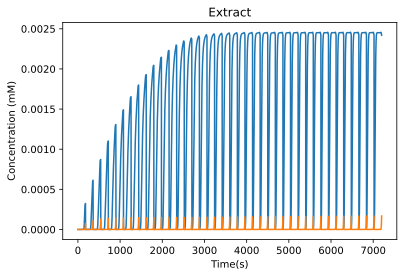

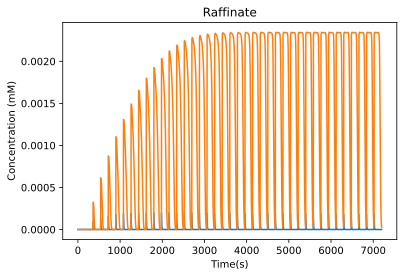

In [7]:
# Run simulation and plot results
run_simulation(smb_model)

plt.figure()
plt.plot(smb_model.root.output.solution.solution_times,
    smb_model.root.output.solution.unit_002.solution_outlet)
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')
plt.title('Extract')


plt.figure()
plt.plot(smb_model.root.output.solution.solution_times,
    smb_model.root.output.solution.unit_003.solution_outlet)
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')
plt.title('Raffinate')